# Sentiment Analysis with ParsBERT

In [ ]:
from google.colab import drive
 
# Accessing My Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


## The NVIDIA System Management Interface (nvidia-smi) is a command line utility, based on top of the NVIDIA Management Library (NVML), intended to aid in the management and monitoring of NVIDIA GPU devices.

In [ ]:
!nvidia-smi

Tue May 31 17:39:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Install & import Libraries

In [ ]:
# Import required packages (If You Need Any More Packages, You Can Add them HERE.)
!pip install hazm
!pip install clean-text[gpl]
!pip install -q transformers

from cleantext import clean
import matplotlib.pyplot as plt

import hazm
from hazm import *
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import *
from sklearn.utils import shuffle

import plotly.graph_objects as go

from tqdm.notebook import tqdm

import os
import re
import collections

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 316 kB 5.1 MB/s 
     |████████████████████████████████| 233 kB 56.3 MB/s 
     |████████████████████████████████| 1.4 MB 47.0 MB/s 
  Created wheel for nltk: filename=nltk-3.3-py3-none-any.whl size=1394488 sha256=d9c2f8e4b76adb141830296b4e931c18a5a69666c079edc870a16629bf3e64aa
  Stored in directory: /root/.cache/pip/wheels/9b/fd/0c/d92302c876e5de87ebd7fc0979d82edb93e2d8d768bf71fac4
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp37-cp37m-linux_x86_64.whl size=154703 sha256=224a19a9db9b9dffab3d19e7eda9cfa3a7ca3c9f600bcad2df3c7a6f0ce383d9
  Stored in directory: /root/.cache/pip/wheels/ab/b2/5b/0fe4b8f5c0e65341e8ea7bb3f4a6ebabfe8b1ac31322392dbf
Successfully built nltk libwapiti
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5
Looking in indexes: ht

## Dataset

### Load the data

In [ ]:
!git clone https://github.com/SBU-CE/Deep-Learning.git
data = pd.read_csv('/content/Deep-Learning/spring-2022/assignments/project-3/taghche_5000.csv', encoding='utf-8')
data = data[['comment', 'rate']]
data.head()

Cloning into 'Deep-Learning'...
remote: Enumerating objects: 378, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 378 (delta 48), reused 24 (delta 11), pack-reused 265
Receiving objects: 100% (378/378), 16.18 MiB | 26.90 MiB/s, done.
Resolving deltas: 100% (133/133), done.


,comment,rate
0,اسم کتاب No one writes to the Colonel\nترجمش...,0
1,"طاقچه عزیز،نام کتاب""کسی به سرهنگ نامه نمینویسد...",5
2,بنظرم این اثر مارکز خیلی از صد سال تنهایی که ب...,5
3,به نظر کتاب خوبی میومد اما من از ترجمش خوشم نی...,2
4,کتاب خوبی است,3


In [ ]:
# handle some conflicts with the dataset structure
# you can find a reliable solution, for the sake of the simplicity
# I just remove these bad combinations!
data['rate'] = data['rate'].apply(lambda r: r if r < 6 else None)

data = data.dropna(subset=['rate'])
data = data.dropna(subset=['comment'])
data = data.drop_duplicates(subset=['comment'], keep='first')
data = data.reset_index(drop=True)

### Normalization / Preprocessing

**<font color=red> For simplicity, Transform the rate in a range of 0.0 to 5.0 to a binary form of negative (0) or positive (1) with a threshold. If the rate is less than 3.0, it labeled as negative otherwise specified as positive.</font>**

In [ ]:
##############################################################################################
data['rate'] = data['rate'].apply(lambda r : '0' if r < 3 else '1')
data.head()
##############################################################################################

,comment,rate
0,اسم کتاب No one writes to the Colonel\nترجمش...,0
1,"طاقچه عزیز،نام کتاب""کسی به سرهنگ نامه نمینویسد...",1
2,بنظرم این اثر مارکز خیلی از صد سال تنهایی که ب...,1
3,به نظر کتاب خوبی میومد اما من از ترجمش خوشم نی...,0
4,کتاب خوبی است,1


In [ ]:
data.head()

,comment,rate
0,اسم کتاب No one writes to the Colonel\nترجمش...,0
1,"طاقچه عزیز،نام کتاب""کسی به سرهنگ نامه نمینویسد...",1
2,بنظرم این اثر مارکز خیلی از صد سال تنهایی که ب...,1
3,به نظر کتاب خوبی میومد اما من از ترجمش خوشم نی...,0
4,کتاب خوبی است,1


**<font color=red> Cleaning is the final step in this section. Your cleaned method should be included these steps:</font>**

**<font color=red>- fixing unicodes</font>**

**<font color=red>- removing specials like a phone number, email, url, new lines, ...</font>**

**<font color=red>- cleaning HTMLs</font>**

**<font color=red>- normalizing</font>**

**<font color=red>- removing emojis</font>**

**<font color=red>- removing extra spaces, hashtags</font>**

In [ ]:
from textwrap import TextWrapper
def remove_emoji(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emotions
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    text = re.sub(emoji_pattern, ' ', text)
    return text

def cleaning(text):
    text = text.strip()
    normalizer = Normalizer()

    ##############################################################################################
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s*[A-Za-z]+\b', '', text)
    text = re.sub(r'[^\w\s]', ' ', text)

    # fixing unicode
    # removing specials like a phone number, email, url, new lines
    text = clean(text,
        fix_unicode=True,
        to_ascii=False,
        lower=True,
        no_line_breaks=True,
        no_urls=True,
        no_emails=True,
        no_phone_numbers=True,
        no_numbers=True,
        no_currency_symbols=True,
        replace_with_url="",
        replace_with_email="",
        replace_with_phone_number="",
        replace_with_number="",
        replace_with_currency_symbol="",
    )
    # normalizing
    text = normalizer.normalize(text)

    # removing emojis
    text = remove_emoji(text)

    # cleaning HTMLs
    text = re.sub(re.compile('<.*?>'), '', text)

    # removing extra spaces, hashtags
    text = re.sub("#", "", text)
    text = re.sub("\s+", " ", text)
    ##############################################################################################
    
    
    return text

In [ ]:
# cleaning comments
data['cleaned_comment'] = data['comment'].apply(cleaning)
data.head(100)

,comment,rate,cleaned_comment
0,اسم کتاب No one writes to the Colonel\nترجمش...,0,اسم کتاب ترجمش میشه کسی به سرهنگ نامه نمینویسد...
1,"طاقچه عزیز،نام کتاب""کسی به سرهنگ نامه نمینویسد...",1,طاقچه عزیز نام کتاب کسی به سرهنگ نامه نمینویسد...
2,بنظرم این اثر مارکز خیلی از صد سال تنهایی که ب...,1,بنظرم این اثر مارکز خیلی از صد سال تنهایی که ب...
3,به نظر کتاب خوبی میومد اما من از ترجمش خوشم نی...,0,به نظر کتاب خوبی میومد اما من از ترجمش خوشم نی...
4,کتاب خوبی است,1,کتاب خوبی است
...,...,...,...
95,لطفا نسخه epub هم قرار بدید,1,لطفا نسخه هم قرار بدید
96,این کتاب سه راهی ک برای خداشناسی وجود دارد را ...,1,این کتاب سه راهی ک برای خداشناسی وجود دارد را ...
97,عالی. عالی. عالی.,1,عالی عالی عالی
98,کتاب بسیار زبیایی است,1,کتاب بسیار زبیایی است


**<font color=red> Calculate the Length of Comments based on their Words</font>**

In [ ]:
##############################################################################################
data['comment_length'] = data['cleaned_comment'].apply(lambda c: len(word_tokenize(c)))
##############################################################################################

**<font color=red> Remove Comments with the Length of Fewer than 3 Words & More than 256 Words</font>**

In [ ]:
##############################################################################################
data['comment_length'] = data['comment_length'].apply(lambda l: l if 3 < l <= 256 else None)
data = data.dropna(subset=['comment_length'])
data = data.reset_index(drop=True)
##############################################################################################

In [ ]:
data = data[['cleaned_comment', 'rate']]
data.columns = ['comment', 'rate']
data.head()

,comment,rate
0,اسم کتاب ترجمش میشه کسی به سرهنگ نامه نمینویسد...,0
1,طاقچه عزیز نام کتاب کسی به سرهنگ نامه نمینویسد...,1
2,بنظرم این اثر مارکز خیلی از صد سال تنهایی که ب...,1
3,به نظر کتاب خوبی میومد اما من از ترجمش خوشم نی...,0
4,راستش خیلی خوشم نیومد ازش,1


### Handling Unbalanced Data

**<font color=red> Because the Data is Unbalanced, You should Balance it. Before & After Balancing Data, You should Plot a Bar Chart of Distribution of label within comments [DATA]</font>**

1    3297
0     746
Name: rate, dtype: int64


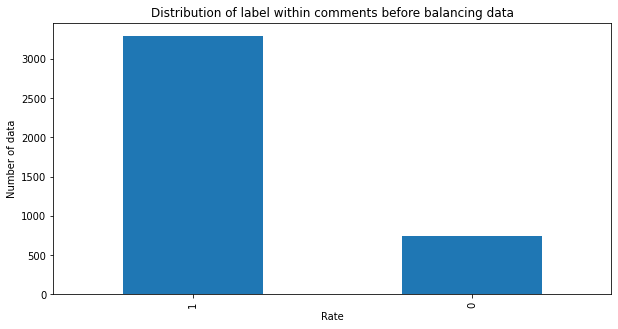

746
1    746
0    746
Name: rate, dtype: int64


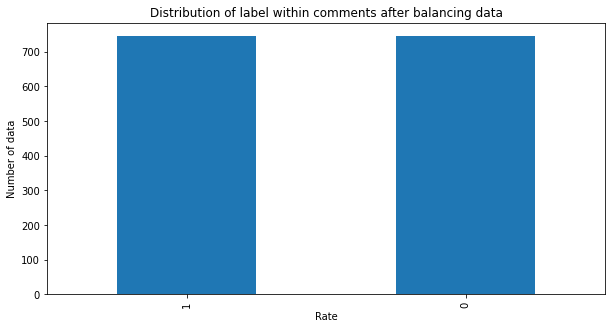

In [ ]:
##############################################################################################
# plot Distribution of label within comments before balancing data
print(data['rate'].value_counts())
data['rate'].value_counts().plot(kind='bar', figsize=(10, 5))
plt.xlabel("Rate")
plt.ylabel("Number of data")
plt.title("Distribution of label within comments before balancing data")
plt.show()

# balancing data 
df_one = data[data['rate']=="1"]
df_zero = data[data['rate']=="0"]

print(len(df_zero))

df_one_downsample = resample(df_one, replace=False, n_samples=len(df_zero), random_state=49) 
 
new_data = pd.concat([df_one_downsample, df_zero])

# plot Distribution of label within comments after balancing data
print(new_data['rate'].value_counts())
new_data['rate'].value_counts().plot(kind='bar', figsize=(10, 5))
plt.xlabel("Rate")
plt.ylabel("Number of data")
plt.title("Distribution of label within comments after balancing data")
plt.show()


##############################################################################################

## Train,Validation,Test split

To achieve a globalized model, we need to split the cleaned dataset into train, valid, test sets due to size of the data. In this tutorial, I have considered a rate of **0.1** for both *valid*, *test* sets. For splitting, I use `train_test_split` provided by Sklearn package with stratifying on the label for preserving the distribution balance.

In [ ]:
new_data['label_id'] = new_data['rate'].apply(lambda t: ["0","1"].index(t))

print(new_data.head())
print(new_data.info())

train, test = train_test_split(new_data, test_size=0.1, random_state=1, stratify=new_data['rate'])
train, valid = train_test_split(train, test_size=0.1, random_state=1, stratify=train['rate'])

train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
test = test.reset_index(drop=True)

x_train, y_train = train['comment'].values.tolist(), train['label_id'].values.tolist()
x_valid, y_valid = valid['comment'].values.tolist(), valid['label_id'].values.tolist()
x_test, y_test = test['comment'].values.tolist(), test['label_id'].values.tolist()

print(train.shape)
print(valid.shape)
print(test.shape)

                                                comment rate  label_id
2927  قطعا باید از رادیو تشکر کنم که سبب آشنایی شد چ...    1         1
2883  کتاب‌های پائولو همیشه گیرایی خاصی برام داشت و ...    1         1
898   سلام کتاب بسیار خوبی است و دید جدیدی در رابطه ...    1         1
2465  لطفا کتاب‌های نیمه پنهان ماه از شهید همت و شهی...    1         1
3169  عالیه باید بگم که رذیلت‌های اخلاقی رو خیلی خوب...    1         1
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1492 entries, 2927 to 4035
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   comment   1492 non-null   object
 1   rate      1492 non-null   object
 2   label_id  1492 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 46.6+ KB
None
(1207, 3)
(135, 3)
(150, 3)


![BERT INPUTS](https://res.cloudinary.com/m3hrdadfi/image/upload/v1595158991/kaggle/bert_inputs_w8rith.png)

As you may know, the BERT model input is a combination of 3 embeddings.
- Token embeddings: WordPiece token vocabulary (WordPiece is another word segmentation algorithm, similar to BPE)
- Segment embeddings: for pair sentences [A-B] marked as $E_A$ or $E_B$ mean that it belongs to the first sentence or the second one.
- Position embeddings: specify the position of words in a sentence

## PyTorch

In [ ]:
# Import required packages (If You Need Any More Packages, You Can Add them HERE.)
from transformers import BertConfig, BertTokenizer
from transformers import BertModel

from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import torch
import torch.nn as nn
import torch.nn.functional as F

### Configuration

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device: cuda:0
CUDA is available!  Training on GPU ...


In [ ]:
# general config
MAX_LEN = 128
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16

EPOCHS = 10
EEVERY_EPOCH = 1000
LEARNING_RATE = 2e-5
CLIP = 0.0

MODEL_NAME_OR_PATH = 'HooshvareLab/bert-fa-base-uncased'
OUTPUT_PATH = '/content/drive/MyDrive/deep/hw3/bert-fa-base-uncased-sentiment-taaghceh/pytorch_model.bin'

os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)

In [ ]:
# create a key finder based on label 2 id and id to label

label2id = {label: i for i, label in enumerate(["0","1"])}
id2label = {v: k for k, v in label2id.items()}

print(f'label2id: {label2id}')
print(f'id2label: {id2label}')

label2id: {'0': 0, '1': 1}
id2label: {0: '0', 1: '1'}


**<font color=red> Setup the Tokenizer and Configuration</font>**

In [ ]:
##############################################################################################
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME_OR_PATH)
config = BertConfig.from_pretrained(
    MODEL_NAME_OR_PATH, **{
        'label2id': label2id,
        'id2label': id2label,
    })

print(config.to_json_string())
##############################################################################################

Downloading:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440 [00:00<?, ?B/s]

{
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "0",
    "1": "1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "0": 0,
    "1": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 100000
}



### Input Embeddings

### Dataset

In [ ]:
class TaaghcheDataset(torch.utils.data.Dataset):
    """ Create a PyTorch dataset for Taaghche. """

    def __init__(self, tokenizer, comments, targets=None, label_list=None, max_len=128):
        self.comments = comments
        self.targets = targets
        self.has_target = isinstance(targets, list) or isinstance(targets, np.ndarray)

        self.tokenizer = tokenizer
        self.max_len = max_len

        
        self.label_map = {label: i for i, label in enumerate(label_list)} if isinstance(label_list, list) else {}
    
    def __len__(self):
        return len(self.comments)

    def __getitem__(self, item):
        comment = str(self.comments[item])

        if self.has_target:
            target = self.label_map.get(str(self.targets[item]), str(self.targets[item]))

        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt')
        
        inputs = {
            'comment': comment,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
        }

        if self.has_target:
            inputs['targets'] = torch.tensor(target, dtype=torch.long)
        
        return inputs


def create_data_loader(x, y, tokenizer, max_len, batch_size, label_list):
    dataset = TaaghcheDataset(
        comments=x,
        targets=y,
        tokenizer=tokenizer,
        max_len=max_len, 
        label_list=label_list)
    
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [ ]:
label_list = ["0", "1"]
train_data_loader = create_data_loader(train['comment'].to_numpy(), train['rate'].to_numpy(), tokenizer, MAX_LEN, TRAIN_BATCH_SIZE, label_list)
valid_data_loader = create_data_loader(valid['comment'].to_numpy(), valid['rate'].to_numpy(), tokenizer, MAX_LEN, VALID_BATCH_SIZE, label_list)
test_data_loader = create_data_loader(test['comment'].to_numpy(), None, tokenizer, MAX_LEN, TEST_BATCH_SIZE, label_list)

In [ ]:
sample_data = next(iter(train_data_loader))

print(sample_data['comment'])
print(sample_data['input_ids'][0, :])
print(sample_data['attention_mask'][0, :])
print(sample_data['token_type_ids'][0, :])
print(sample_data['targets'][0])

['عالی ان شاء الله که با شهدای کربلا محشور شود ماشاء الله لاحول و لا قوة الا بالله العلی العظیم', 'این چه وضعشه دیگه من این کتاب رو میخرم چرا مثلا مجاز نیست حالا که پولشو دادم برم از سایتای دیگه رو دانلود کنم', 'فقط و فقط میتونم بگم بینظیره قلم نویسنده عالیه و اشک آدم ناخودآگاه در میاد', 'والا بعنوان کسی که زیاد حرفه\u200cای مطالعه نمیکنه و ندارم اصلا نتونستم باهاش ارتباط برقرار کنم و تا کلی صفحه هم پیش رفتم ولی چیزی متوجه نشدم و بی خیال شدم', 'ترجمه سرسری و وحشتناک', 'من این کتاب رو چند روز پیش شروع کردم به نظرم یکی از بهترین کتابای تاریخیه که تلفیقی از رمان و تاریخ هستش', 'اقا من سی صفحه از این کتاب رو خوندم هیچی نفهمیدم گیج کننده س پر از اسم و شخصیته و گنگ هست چطوره کتابش ادامه بدم', 'کتاب خویشتن پنهان رو به هر کسی که بخواد خودش رو پیدا کنه و دنیا رو متفاوت ببینه و درک متفاوتی از زندگی داشته باشه توصیه میکنم رایگان بودن کتاب رو غنیمت بشمرید و با حوصله و صبر مطالعه کنید', 'خیلی خسته کننده بود ارزش خوندن نداشت', 'سلام من نمیتونم این کتاب رو باز کنم کتاب رو حذف کردم و دوباره دانلود کرد

### Model

**<font color=red> Complete forward function</font>**

In [ ]:
class SentimentModel(nn.Module):

    def __init__(self, config):
        super(SentimentModel, self).__init__()

        self.bert = BertModel.from_pretrained(MODEL_NAME_OR_PATH,return_dict=False)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
    
    def forward(self,input_ids, attention_mask, token_type_ids):
        ##############################################################################################
        _, cls_hs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        x = self.dropout(cls_hs)
        x = self.classifier(x)
        ##############################################################################################
        return x 

In [ ]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()
pt_model = None

!nvidia-smi

Tue May 31 17:39:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
pt_model = SentimentModel(config=config)
pt_model = pt_model.to(device)

print('pt_model', type(pt_model))

Downloading:   0%|          | 0.00/624M [00:00<?, ?B/s]

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


pt_model <class '__main__.SentimentModel'>


### Training

**<font color=red> Complete functions</font>**

In [ ]:
def acc_and_f1(y_true, y_pred, average='weighted'):
    # Define Accuracy and F1-score
    ##############################################################################################
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    ##############################################################################################
    return acc, f1

def y_loss(y_true, y_pred, losses):
    y_true = torch.stack(y_true).cpu().detach().numpy()
    y_pred = torch.stack(y_pred).cpu().detach().numpy()
    y = [y_true, y_pred]
    loss = np.mean(losses)

    return y, loss


def eval_op(model, data_loader, loss_fn):
    model.eval()

    losses = []
    y_pred = []
    y_true = []

    with torch.no_grad():
        for dl in tqdm(data_loader, total=len(data_loader), desc="Evaluation... "):

            # Define input_ids, attention_mask, token_type_ids, targets
            ##############################################################################################
            input_ids = dl['input_ids']
            attention_mask = dl['attention_mask']
            token_type_ids = dl['token_type_ids']
            targets = dl['targets']
            ##############################################################################################


            # move tensors to GPU if CUDA is available
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            targets = targets.to(device)

            # compute predicted outputs by passing inputs to the model
            ##############################################################################################
            output = model(input_ids, attention_mask, token_type_ids)
            ##############################################################################################
            
            # convert output probabilities to predicted class
            ##############################################################################################
            _, preds = torch.max(output, dim=1)
            ##############################################################################################

            # calculate the batch loss
            ##############################################################################################
            loss = loss_fn(output, targets)
            ##############################################################################################

            # accumulate all the losses
            losses.append(loss.item())

            y_pred.extend(preds)
            y_true.extend(targets)
    
    eval_y, eval_loss = y_loss(y_true, y_pred, losses)
    return eval_y, eval_loss


def train_op(model, 
             data_loader, 
             loss_fn, 
             optimizer, 
             scheduler, 
             step=0, 
             print_every_step=100, 
             eval=False,
             eval_cb=None,
             eval_loss_min=np.Inf,
             eval_data_loader=None, 
             clip=0.0):
    
    model.train()

    losses = []
    y_pred = []
    y_true = []

    for dl in tqdm(data_loader, total=len(data_loader), desc="Training... "):
        step += 1

        # Define input_ids, attention_mask, token_type_ids, targets
        ##############################################################################################
        input_ids = dl['input_ids']
        attention_mask = dl['attention_mask']
        token_type_ids = dl['token_type_ids']
        targets = dl['targets']
        ##############################################################################################

        # move tensors to GPU if CUDA is available
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        targets = targets.to(device)

        # clear the gradients of all optimized variables
        optimizer.zero_grad()

        # compute predicted outputs by passing inputs to the model
        ##############################################################################################
        output = model(input_ids, attention_mask, token_type_ids)
        ##############################################################################################
        
        # convert output probabilities to predicted class
        ##############################################################################################
        _, preds = torch.max(output, dim=1)
        ##############################################################################################

        # calculate the batch loss
        ##############################################################################################
        loss = loss_fn(output, targets)
        ##############################################################################################

        # accumulate all the losses
        losses.append(loss.item())

        # compute gradient of the loss with respect to model parameters
        loss.backward()

        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        if clip > 0.0:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)

        # perform optimization step
        optimizer.step()

        # perform scheduler step
        scheduler.step()

        y_pred.extend(preds)
        y_true.extend(targets)

        if eval:
            train_y, train_loss = y_loss(y_true, y_pred, losses)
            train_acc, train_f1 = acc_and_f1(train_y[0], train_y[1], average='weighted')

            if step % print_every_step == 0:
                eval_y, eval_loss = eval_op(model, eval_data_loader, loss_fn)
                eval_acc, eval_f1 = acc_and_f1(eval_y[0], eval_y[1], average='weighted')

                if hasattr(eval_cb, '__call__'):
                    eval_loss_min = eval_cb(model, step, [train_acc, train_f1], train_loss, [eval_acc, eval_f1], eval_loss, eval_loss_min)

    train_y, train_loss = y_loss(y_true, y_pred, losses)

    return train_y, train_loss, step, eval_loss_min

**<font color=red> Define Optimizer, Scheduler & Loss Function</font>**

In [ ]:
#######################################Your Code#############################################
optimizer = AdamW(pt_model.parameters(), lr=LEARNING_RATE, correct_bias=False)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps = len(train_data_loader) * EPOCHS)
loss_fn =  nn.CrossEntropyLoss()                                                                               
##############################################################################################

step = 0
eval_loss_min = np.Inf
history = collections.defaultdict(list)


def eval_callback(epoch, epochs, output_path):
    def eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min):
        statement = ''
        statement += 'Epoch: {}/{}...'.format(epoch, epochs)
        statement += 'Step: {}...'.format(step)
        
        statement += 'Train Loss: {:.6f}...'.format(train_loss)
        statement += 'Train Acc: {:.3f}...'.format(train_score[0])

        statement += 'Valid Loss: {:.6f}...'.format(eval_loss)
        statement += 'Valid Acc: {:.3f}...'.format(eval_score[0])

        print(statement)

        if eval_loss <= eval_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                eval_loss_min,
                eval_loss))
            
            torch.save(model.state_dict(), output_path)
            eval_loss_min = eval_loss
        
        return eval_loss_min


    return eval_cb


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


**<font color=red> Complete Training & Plot Loss and Accuracy Diagram</font>**

In [ ]:
for epoch in tqdm(range(1, EPOCHS + 1), desc="Epochs... "):

    # Define train_y, train_loss, step, eval_loss_min using train_op
    ##############################################################################################
    train_y, train_loss, step, eval_loss_min = train_op(pt_model,train_data_loader,loss_fn,optimizer, scheduler,step, 100, eval=True, 
                                                        eval_cb=eval_callback(epoch, EPOCHS, OUTPUT_PATH), eval_loss_min = eval_loss_min,eval_data_loader = valid_data_loader)
    ##############################################################################################

    # Define train_score using acc_and_f1
    ##############################################################################################
    train_acc, train_f1 = acc_and_f1(train_y[0], train_y[1])
    ##############################################################################################
    
    # Define eval_y, eval_loss using eval_op
    ##############################################################################################
    eval_y, eval_loss = eval_op(pt_model,valid_data_loader, loss_fn)
    ##############################################################################################
    
    # Define eval_score using acc_and_f1
    ##############################################################################################
    val_acc, val_f1 = acc_and_f1(eval_y[0], eval_y[1])
    ##############################################################################################
    
    # Save Accuracy and Loss values
    ##############################################################################################
    history['train_acc'].append(train_acc)
    history['train_f1'].append(train_f1)
    history['train_loss'].append(train_loss)

    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    history['val_loss'].append(eval_loss)
    ##############################################################################################


Epochs... :   0%|          | 0/10 [00:00<?, ?it/s]

Training... :   0%|          | 0/76 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/9 [00:00<?, ?it/s]

Training... :   0%|          | 0/76 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 2/10...Step: 100...Train Loss: 0.064408...Train Acc: 0.990...Valid Loss: 0.999462...Valid Acc: 0.696...
Validation loss decreased (inf --> 0.999462).  Saving model ...


Evaluation... :   0%|          | 0/9 [00:00<?, ?it/s]

Training... :   0%|          | 0/76 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 3/10...Step: 200...Train Loss: 0.022278...Train Acc: 0.996...Valid Loss: 1.262617...Valid Acc: 0.674...


Evaluation... :   0%|          | 0/9 [00:00<?, ?it/s]

Training... :   0%|          | 0/76 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 4/10...Step: 300...Train Loss: 0.020203...Train Acc: 0.995...Valid Loss: 1.445434...Valid Acc: 0.696...


Evaluation... :   0%|          | 0/9 [00:00<?, ?it/s]

Training... :   0%|          | 0/76 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/9 [00:00<?, ?it/s]

Training... :   0%|          | 0/76 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 6/10...Step: 400...Train Loss: 0.006857...Train Acc: 1.000...Valid Loss: 1.307891...Valid Acc: 0.681...


Evaluation... :   0%|          | 0/9 [00:00<?, ?it/s]

Training... :   0%|          | 0/76 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 7/10...Step: 500...Train Loss: 0.004673...Train Acc: 0.999...Valid Loss: 1.531868...Valid Acc: 0.689...


Evaluation... :   0%|          | 0/9 [00:00<?, ?it/s]

Training... :   0%|          | 0/76 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 8/10...Step: 600...Train Loss: 0.003125...Train Acc: 0.999...Valid Loss: 1.644557...Valid Acc: 0.696...


Evaluation... :   0%|          | 0/9 [00:00<?, ?it/s]

Training... :   0%|          | 0/76 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/9 [00:00<?, ?it/s]

Training... :   0%|          | 0/76 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 10/10...Step: 700...Train Loss: 0.000580...Train Acc: 1.000...Valid Loss: 1.689256...Valid Acc: 0.696...


Evaluation... :   0%|          | 0/9 [00:00<?, ?it/s]

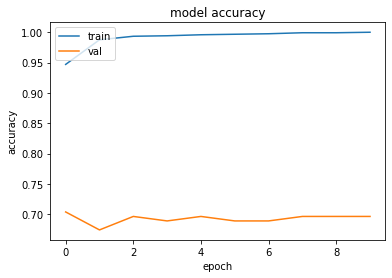

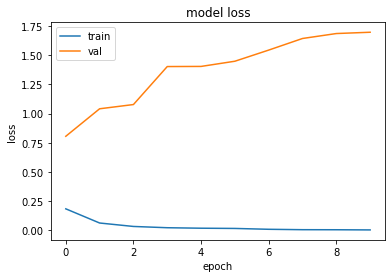

In [ ]:
# Diagram
##############################################################################################
plt.plot(history['train_acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history['train_loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
##############################################################################################


### Prediction

**<font color=red> Complete function</font>**

In [ ]:
def predict(model, comments, tokenizer, max_len=128, batch_size=32):
    data_loader = create_data_loader(comments, None, tokenizer, max_len, batch_size, None)
    
    predictions = []
    prediction_probs = []

    
    model.eval()
    with torch.no_grad():
        for dl in tqdm(data_loader, position=0):

            # Define input_ids, attention_mask, token_type_ids
            ##############################################################################################
            input_ids = dl['input_ids']
            attention_mask = dl['attention_mask']
            token_type_ids = dl['token_type_ids']
            ##############################################################################################

            # move tensors to GPU if CUDA is available
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            
            # compute predicted outputs by passing inputs to the model
            ##############################################################################################
            output = model(input_ids, attention_mask, token_type_ids)
            ##############################################################################################
            
            # convert output probabilities to predicted class
            ##############################################################################################
            _, preds = torch.max(output, dim=1)
            ##############################################################################################

            predictions.extend(preds)
            prediction_probs.extend(F.softmax(output, dim=1))

    predictions = torch.stack(predictions).cpu().detach().numpy()
    prediction_probs = torch.stack(prediction_probs).cpu().detach().numpy()

    return predictions, prediction_probs

In [ ]:
test_comments = test['comment'].to_numpy()
preds, probs = predict(pt_model, test_comments, tokenizer, max_len=128)

print(preds.shape, probs.shape)

  0%|          | 0/5 [00:00<?, ?it/s]

(150,) (150, 2)


**<font color=red> Evaluate Your Model using f1-score & Precision & Recall</font>**

In [ ]:
##############################################################################################
y_test =test['rate'].apply(lambda l : ["0","1"].index(l))
print(classification_report(y_test, preds, target_names=["0", "1"]))
##############################################################################################

              precision    recall  f1-score   support

           0       0.71      0.75      0.73        75
           1       0.73      0.69      0.71        75

    accuracy                           0.72       150
   macro avg       0.72      0.72      0.72       150
weighted avg       0.72      0.72      0.72       150

